In [1]:
# Imports
import csv
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Intro
The relationship between musica  characteristics of each song and the popularity of each song is important for music production and song artists companies to create the next bit songs hits. The Spotify dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021 along with each song’s genre, song artist id, and various musical attributes. The popularity score of each song is a number ranging from 0 to 100 that is used by Spotify to rank each song’s popularity. In this project, we will attempt to predict song popularity based on both song metadata as well as musical features generated by Spotify in-house algorithms. Our classification algorithm can be used by musical production comapnies and song artists to gauge how successful each candidate song would be.

# Data Prep

This dataset contains songs that were on the Top 200 Weekly Global charts for Spotify in 2020 & 2021. For each song, we have the following features.

| Feature                   | Feature Type |
|---------------------------|--------------|
| Highest Charting Position | Numeric      |
| Number of Times Charted   | Numeric      |
| Song Name                 | Categorical  |
| Song ID                   | Categorical  |
| Artist                    | Categorical  |
| Streams                   | Numeric      |
| Artist Followers          | Numeric      |
| Genre                     | Categorical  |
| Release Date              | Numeric      |
| Weeks Charted             | Numeric      |
| Popularity                | Numeric      |
| Danceability              | Numeric      |
| Acousticness              | Numeric      |
| Energy                    | Numeric      |
| Instrumentalness          | Numeric      |
| Loudness                  | Numeric      |
| Speechiness               | Numeric      |
| Tempo                     | Numeric      |
| Valence                   | Numeric      |
| Chord                     | Numeric      |



In [2]:
# Entire Dataset
path = 'spotify_dataset.csv'
data = pd.DataFrame(pd.read_csv(path))
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


## Cleaning the dataset

### Removing irrelevant columns and missing values
For our analysis, we will exclude song name and song id from our feature set.  We will also drop any records that do not have any classified song genres, chords, or duration.

In [3]:
# Drop columns corresponding to: index, song name, song id
columns_to_exclude = [0, 4, 8]
data.drop(columns=data.columns[columns_to_exclude], inplace=True)

# some songs have no defined Chord
print('Songs with no defined Chord', np.sum([data['Chord'] == ' ']))
# some song have not defined genre
print("Song with no genre", np.sum([data['Genre'] == '[]']))
# some songs have no defined duration
print('Songs with no defined Duration', np.sum([data["Duration (ms)"] == ' ']))

# Drop rows with missing values
data['Chord'].replace(' ', np.nan, inplace=True)
data['Genre'].replace('[]', np.nan, inplace=True)
data['Duration (ms)'].replace(' ', np.nan, inplace=True)
data.dropna(inplace=True)

Songs with no defined Chord 11
Song with no genre 75
Songs with no defined Duration 11


### Fixing Data Types

In [4]:
# fixing dtypes of values, so that they're floats
data['Streams'] = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
types = {'Artist Followers':'int64', 'Duration (ms)':'int64', 'Popularity':'float','Danceability':'float', 'Acousticness':'float', 'Energy':'float', 'Liveness':'float','Loudness':'float', 'Speechiness':'float', 'Tempo':'float', 'Valence':'float'}
data = data.astype(types)

### Mapping Categorical Features to Classes

In [5]:
# Converting each artist to a class
artists = data['Artist'].tolist()
artists_set = set()
for artist in artists:
    multiple_artists = artist.split(", ")
    for each_artist in multiple_artists:
        artists_set.add(each_artist)

classes = range(len(artists_set))
artists_to_class = dict(zip(artists_set, classes))

# Adding classes as a column
artist_column = [[artists_to_class.get(each_artist) for each_artist in artist.split(", ")] for artist in artists]
data.insert(5, 'Artist_Class', artist_column)

In [6]:
# Converting each chord to a class
chords = set(data['Chord'].tolist())

classes = range(len(chords))
chords_to_class = dict(zip(chords, classes))

# Adding classes as a column
chord_column = [chords_to_class.get(chord_name) for chord_name in data['Chord'].tolist()]
data['Chord_Class'] = chord_column

In [7]:
genre_feat = data["Genre"].tolist()
genres = []
for feat_list in genre_feat:
    # Parse genres
    temp = feat_list.replace("'", "")
    temp = temp.replace("[", "")
    temp = temp.replace("]", "")
    temp = temp.replace(" ", "")
    feats  = temp.split(",")
    song_genre = set()
    # Replace all pop, rock, rap, and hiphop genres with general genres
    for feat in feats:
        if "pop" in feat:
            song_genre.add("pop")
        elif "rock" in feat:
            song_genre.add("rock")
        elif "rap" in feat:
            song_genre.add("rap")
        elif "hiphop" in feat:
            song_genre.add("hiphop")
        else:
            song_genre.add(feat)
    genres.append(song_genre)
        
# Find genre frequencies
genre_freq = Counter([genre for song_genres in genres for genre in song_genres])

# Replace song genres with the most common genre
for i in range(len(genres)):
    song_genres = list(genres[i])
    max_freq_genre = None
    max_freq = -1
    for j in range(len(song_genres)):
        cur_freq = genre_freq.get(song_genres[j])
        if max_freq < cur_freq:
            max_freq = cur_freq
            max_freq_genre = song_genres[j]
    genres[i] = max_freq_genre

# Converting each genre to a class
unique_genres = set(genres)

classes = range(len(unique_genres))
genres_to_class = dict(zip(genres, classes))

# Adding classes as a column
genre_column = [genres_to_class.get(genre_name) for genre_name in genres]
data['Genre_Class'] = genre_column

In [8]:
data.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist,Artist_Class,Artist Followers,Genre,Release Date,Weeks Charted,...,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,Chord_Class,Genre_Class
0,1,8,2021-07-23--2021-07-30,48633449,Måneskin,[48],3377762,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-4.808,0.0504,0.1270,0.3590,134.002,211560,0.589,B,7,33.0
1,2,3,2021-07-23--2021-07-30,47248719,The Kid LAROI,[212],2230022,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.484,0.0483,0.0383,0.1030,169.928,141806,0.478,C#/Db,9,29.0
2,1,11,2021-06-25--2021-07-02,40162559,Olivia Rodrigo,[241],6266514,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-5.044,0.1540,0.3350,0.0849,166.928,178147,0.688,A,10,33.0
3,3,5,2021-07-02--2021-07-09,37799456,Ed Sheeran,[146],83293380,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,...,-3.712,0.0348,0.0469,0.3640,126.026,231041,0.591,B,7,33.0
4,5,1,2021-07-23--2021-07-30,33948454,Lil Nas X,[249],5473565,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,...,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb,11,33.0


# Data Exploration

In [9]:
# Check for Noise and Outliers


<ipython-input-10-d6b8b40cf500>:11: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax.pie(percentages, labels=labels)


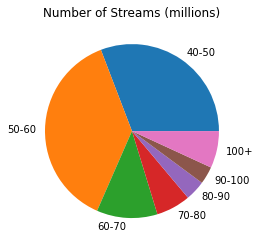

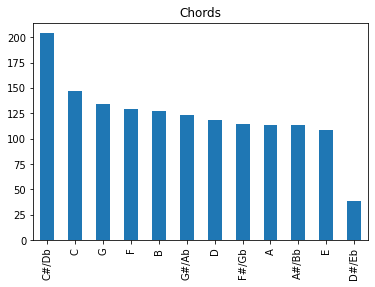

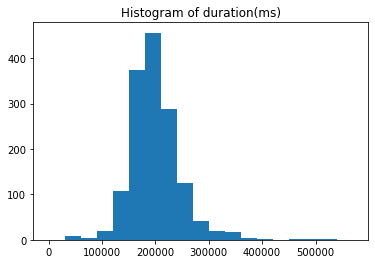

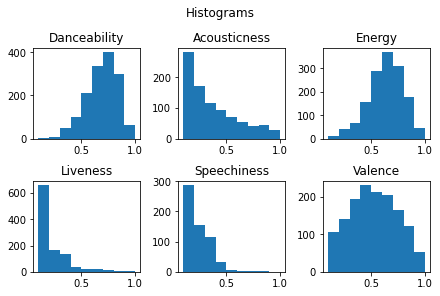

In [10]:
# Exploring

stream_bins = list(range(0, 10000001, 1000000)) + [99999999]
# streams = [int(stream.replace(',', '')) for stream in data['Streams'].tolist()]
hist, bin_edges = np.histogram(data['Streams'], bins=stream_bins)
percentages = hist/np.sum(hist)
labels = np.array(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100+'])
labels = labels[percentages != 0]
percentages = percentages[percentages != 0]
fig, ax = plt.subplots(1, 1)
ax.pie(percentages, labels=labels)
ax.set_title('Number of Streams (millions)')
plt.show()

# should sort chords from low to high?
ax = data['Chord'].value_counts().plot.bar()
ax.set_title('Chords')
plt.show()

duration_bins = list(range(0, 30000*2*10, 30000))
fig, ax = plt.subplots(1, 1)
ax.hist(pd.to_numeric(data["Duration (ms)"]), bins=duration_bins)
ax.ticklabel_format(style='plain')
ax.set_title('Histogram of duration(ms)')
plt.show()

zero_to_one_bins = np.linspace(0.1, 1.0, 10)
fig, ax = plt.subplots(2, 3, constrained_layout=True)
zero_to_one_columns = ['Danceability', 'Acousticness', 'Energy', 'Liveness', 'Speechiness', 'Valence']
for i in range(len(zero_to_one_columns)):
    idx = np.unravel_index(i, (2, 3))
    ax[idx].hist(pd.to_numeric(data[zero_to_one_columns[i]]), bins=zero_to_one_bins)
    ax[idx].set_title(zero_to_one_columns[i])
fig.suptitle('Histograms')
plt.show()

In [11]:
# Exploring 

data.groupby('Number of Times Charted').describe()['Highest Charting Position']

,count,mean,std,min,25%,50%,75%,max
Number of Times Charted,,,,,,,,
1,491.0,128.949084,47.672859,5.0,87.00,134.0,171.0,200.0
2,146.0,81.767123,50.590178,10.0,43.00,66.5,111.5,194.0
3,106.0,82.754717,55.189166,2.0,34.00,71.0,128.0,193.0
4,67.0,86.119403,53.110098,10.0,49.00,71.0,132.0,194.0
5,66.0,79.333333,51.563354,3.0,38.25,69.5,120.0,189.0
...,...,...,...,...,...,...,...,...
81,2.0,61.000000,28.284271,41.0,51.00,61.0,71.0,81.0
82,2.0,57.000000,52.325902,20.0,38.50,57.0,75.5,94.0
83,15.0,27.133333,31.854281,1.0,4.00,13.0,38.5,99.0


In [12]:
# Exploring

data.corr(method='pearson')

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_Class,Genre_Class
Highest Charting Position,1.000000,-0.410595,-0.298790,-0.247796,-0.320234,0.021647,0.061294,0.033320,0.045668,-0.021258,0.005447,0.026284,-0.037091,0.051415,0.032417,0.020111
Number of Times Charted,-0.410595,1.000000,-0.061799,0.035791,0.455422,0.024082,-0.046415,0.047012,-0.068676,0.041189,-0.050636,-0.049898,0.035513,0.024569,-0.016337,0.008573
Streams,-0.298790,-0.061799,1.000000,0.100240,0.142846,-0.086556,0.004738,-0.030966,-0.061597,0.037113,0.043044,0.057788,0.017649,0.033661,0.076197,0.030862
Artist Followers,-0.247796,0.035791,0.100240,1.000000,0.003354,-0.107970,-0.072213,-0.036164,-0.087508,0.041055,-0.020931,-0.016717,0.133528,-0.102008,-0.017695,0.025980
Popularity,-0.320234,0.455422,0.142846,0.003354,1.000000,0.039565,0.111469,0.200443,-0.098915,-0.095474,-0.087994,-0.042767,0.078418,0.017242,-0.036831,0.002926
Danceability,0.021647,0.024082,-0.086556,-0.107970,0.039565,1.000000,0.139572,0.234814,0.238119,-0.317818,-0.117369,-0.030442,-0.106726,0.357089,0.026617,-0.184638
Energy,0.061294,-0.046415,0.004738,-0.072213,0.111469,0.139572,1.000000,0.729818,0.026659,-0.539711,0.124064,0.110788,0.064591,0.346834,-0.027326,-0.069166
Loudness,0.033320,0.047012,-0.030966,-0.036164,0.200443,0.234814,0.729818,1.000000,-0.013791,-0.473206,0.040444,0.104720,0.086502,0.287641,0.010185,-0.061276
Speechiness,0.045668,-0.068676,-0.061597,-0.087508,-0.098915,0.238119,0.026659,-0.013791,1.000000,-0.135121,0.077980,0.116961,-0.094616,0.046691,0.049601,-0.265695
Acousticness,-0.021258,0.041189,0.037113,0.041055,-0.095474,-0.317818,-0.539711,-0.473206,-0.135121,1.000000,-0.000010,-0.069064,-0.045929,-0.094596,0.006094,0.086451


# Feature Engineering

In [13]:
# Data Scaling and Standardization


In [125]:
# Clean data a bit more
data.dropna(inplace=True)

# drop non-number data (including data we've converted to numbers)
cols_to_drop = ['Week of Highest Charting', 'Artist', 'Genre', 'Release Date', 'Weeks Charted', 'Chord']
data_only_nums = data.drop(cols_to_drop, axis=1)

# only consider first artist for ease, round streams
data_only_nums['Artist_Class'] = data_only_nums.apply(lambda x: x[0], axis=1)

# round streams so we have a chance at predicting it well
data_only_nums['Streams'] = (data_only_nums['Streams'] / 10000000).astype(int) * 10000000
data_only_nums['Artist Followers'] = (data_only_nums['Artist Followers'] / 100000).astype(int) * 100000
print(data_only_nums.head())
print(max(data_only_nums['Highest Charting Position']))

   Highest Charting Position  Number of Times Charted   Streams  Artist_Class  \
0                          1                        8  40000000             1   
1                          2                        3  40000000             2   
2                          1                       11  40000000             1   
3                          3                        5  30000000             3   
4                          5                        1  30000000             5   

   Artist Followers  Popularity  Danceability  Energy  Loudness  Speechiness  \
0           3300000       100.0         0.714   0.800    -4.808       0.0504   
1           2200000        99.0         0.591   0.764    -5.484       0.0483   
2           6200000        99.0         0.563   0.664    -5.044       0.1540   
3          83200000        98.0         0.808   0.897    -3.712       0.0348   
4           5400000        96.0         0.736   0.704    -7.409       0.0615   

   Acousticness  Liveness    Tem

In [121]:
# Create data/labels frames
genre_labels = data_only_nums['Genre_Class'].values.ravel()
genre_data = data_only_nums.drop(['Genre_Class'], axis=1)

charting_labels = data_only_nums['Streams']
charting_data = data_only_nums.drop(['Streams'], axis=1)

print('Genre Data Shape:', genre_data.shape, '\nGenre Labels Shape:', len(genre_labels))
print('Charting Data Shape:', charting_data.shape, '\nCharting Labels Shape:', len(charting_labels))

Genre Data Shape: (1328, 16) 
Genre Labels Shape: 1328
Charting Data Shape: (1328, 16) 
Charting Labels Shape: 1328


# Data Analysis

## Decision Tree

In [124]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# fit a decision tree classifier across 5 cross folds
clf = DecisionTreeClassifier(criterion='entropy')
accuracies = cross_val_score(clf, genre_data, genre_labels, cv=5)
print('Average Accuracy of a Decision Tree on Predicting Genre: %.4f%%' % (np.mean(accuracies) * 100))

clf = DecisionTreeClassifier(criterion='entropy')
accuracies = cross_val_score(clf, charting_data, charting_labels, cv=5)
print('Average Accuracy of a Decision Tree on Predicting Charting Position: %.4f%%' % (np.mean(accuracies) * 100))

# only one fold
# train_data, test_data, train_labels, test_labels = train_test_split(charting_data, charting_labels, test_size=0.20)
# clf = clf.fit(train_data, train_labels)
# pred_labels = clf.predict(test_data)
# print('Accuracy: %.4f%%' % (accuracy_score(test_labels, pred_labels) * 100))

Average Accuracy of a Decision Tree on Predicting Genre: 71.4635%
Average Accuracy of a Decision Tree on Predicting Charting Position: 94.0511%


/Users/ninaahmed/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


A decision tree working well with our data is very surprising, especially with how well it can predict charting position! This makes sense because we have a lot of numerical data like danceability and energy, so the decision tree algorithm must be finding great splits.

# Results